# Todo list:

1. Calibrate the DC value of the accelerometer
1. Convert units to m/s^2 everywhere
2. Calibrate the gyro tilt
3. measure covariances of all the sensors

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
#from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *

import ahrs
from ahrs import Quaternion
from geomag.geomag import GeoMag


In [ ]:
## Geomagnetic data
## coordinates at hillegas x parker in berkeley
lat=37.864
lon=-122.256
gm=GeoMag().GeoMag(lat,lon)
gm.dec
gm.dip

In [84]:
## Read in the data
raw_dat=load_endaq_log("data/accel_cal_")

#Pull out the sensor data synchronized to the magnetometer
dfMag=raw_dat['mag']
ts=dfMag.index.to_numpy(dtype=np.float32)/1e9
ts=ts-ts[0]
mag=dfMag.to_numpy()
gyro=(pi/180)*synchronize_series(raw_dat['gyro'],ref=dfMag).to_numpy()

## the 8g accelerometer is much better than the 16g or the integrated IMU accelerometer
## But there may be a small angle correction between the accelerometer and gyroscope reference axes
acc8=   synchronize_series(raw_dat['acc8'],ref=dfMag).to_numpy()
accIMU= synchronize_series(raw_dat['accIMU'],ref=dfMag).to_numpy()
acc16=  synchronize_series(raw_dat['acc16'],ref=dfMag).to_numpy()



## Apply calibration or corrections!!

In [50]:
## Compute the frequency and number of samples
dt=np.mean(ts[1:]-ts[0:-1])
freq=1/dt
num_samples=len(ts)

# Initialize the AHRS filter
madgwick=ahrs.filters.Madgwick(beta=0.1,frequency=freq)

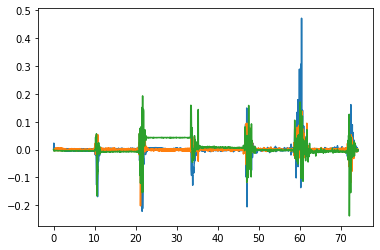

In [89]:
# For each time step apply the estimation filter

# Allocate arrays

# Initial orientation is set as the reference
QMARG= np.tile([1.,0.,0.,0.],(num_samples,1))
QIMU= np.tile([1.,0.,0.,0.],(num_samples,1))
ACC_LAB=np.zeros((num_samples,3))
# Use kalman filter for estimating position + velocity
# state[t]= (x,y,z,vx,vy,vz)
state=np.zeros((num_samples,6))


## Initial state

## Process transition matrix
## x=x0 + v0 dt + 1/2 (a-g) dt^2
A=np.matrix(\
[\
[1,  0,  0,  dt,  0,  0  ] ,\
[0,  1,  0,  0,  dt,  0  ] ,\
[0,  0,  1,  0,  0,  dt  ] ,\
[0,  0,  0,  1,  0,  0   ] ,\
[0,  0,  0,  0,  1,  0   ] ,\
[0,  0,  0,  0,  0,  1   ] ,\
]\
)
## Control matrix
B=np.matrix(\
[\
[dt**2/2,  0,    0    ] ,\
[0,    dt**2/2,  0    ] ,\
[0,        0,  dt**2/2] ,\
[dt,       0,    0    ] ,\
[0,       dt,    0    ] ,\
[0,        0,    dt   ] ,\
]\
)

## Gravity vector
g=np.array([0,0,1])

## set the interval between zeroing the state
zero_period=0.300
next_zero=zero_period


for t in range(1,num_samples):
    
    # Orientation estimation using madwick filter
    QMARG[t]=madgwick.updateMARG(QMARG[t-1],gyro[t],acc8[t],mag[t])
    QIMU[t]=madgwick.updateIMU(QIMU[t-1],gyro[t],acc8[t])
    
    #Rotate the acceleration vector from sensor frame to lab frame
    ACC_LAB[t]=Quaternion(QIMU[t]).rotate(acc8[t])-g
    
    #Update the state using the process and control matrices
    state[t]=A.dot(state[t-1])+B.dot(ACC_LAB[t-1])
    
    
    ## Periodically re-zero the state
    ## This is for inspecting the short-term performance
    if ts[t] > next_zero:
        state[t]=np.zeros(6)
        next_zero=ts[t]+zero_period
    
    
## Plot the quaternions from the two different methods
#ahrs.utils.plot_quaternions(QMARG)
#ahrs.utils.plot_quaternions(QIMU)

## Compare the rotated and unrotated acceleration 
#plt.plot(ts,acc8[:,0])
#plt.plot(ts,acc8[:,1])
#plt.plot(ts,acc8[:,2])

plt.plot(ts,ACC_LAB[:,0])
plt.plot(ts,ACC_LAB[:,1])
plt.plot(ts,ACC_LAB[:,2])


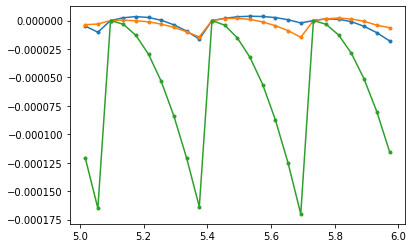

In [96]:
## Inspect the dead-reckoning position estimate
tmax=6
tmin=5
mask=(ts<tmax) & (ts>tmin)
plt.plot(ts[mask],state[mask,0],marker=".")
plt.plot(ts[mask],state[mask,1],marker=".")
plt.plot(ts[mask],state[mask,2],marker=".")

In [83]:
tmax=4
tmin=1
ts=np.array([0,1,2,3,4,5])
(tmin<ts) & (ts<tmax)

array([False, False,  True,  True, False, False])

In [64]:
ts[0:10]

array([0.        , 0.03981   , 0.07962003, 0.11943102, 0.15924102,
       0.19905102, 0.23886096, 0.27867103, 0.31848198, 0.35829204],
      dtype=float32)

In [88]:
2*10**-3/(0.3**2)

0.022222222222222223